In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
import datetime as dt

In [4]:
from IPython.display import display

# Introduction

In [5]:
indexes = ['nifty 50', 'nifty 100', 'nifty 200', 'nifty 500', 'nifty midcap 50', 'nifty midcap 100', 'nifty midcap 150',
           'nifty smallcap 50', 'nifty smallcap 100', 'nifty smallcap 250']

In [6]:
nifty = pd.read_excel(indexes[0]+'.xlsx', index_col='Date')
nifty.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2532 entries, 2011-01-03 to 2021-03-19
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Total Returns Index  2532 non-null   float64
 1   P/E                  2532 non-null   float64
 2   P/B                  2532 non-null   float64
 3   Div Yield            2532 non-null   float64
dtypes: float64(4)
memory usage: 98.9 KB


In [7]:
nifty.describe()

Total Returns Index          P/E          P/B    Div Yield
count          2532.000000  2532.000000  2532.000000  2532.000000
mean          11420.314814    23.097966     3.321299     1.333645
std            3727.377642     4.936782     0.318342     0.161208
min            5763.880000    15.230000     2.170000     0.930000
25%            7685.960000    18.957500     3.070000     1.230000
50%           11051.280000    22.295000     3.360000     1.320000
75%           14571.735000    26.180000     3.540000     1.460000
max           21739.690000    42.000000     4.340000     2.000000

In [8]:
nifty[nifty.duplicated(keep=False)]

Total Returns Index    P/E   P/B  Div Yield
Date                                                   
2014-05-13              9267.61  19.67  3.38       1.36
2014-05-14              9267.61  19.67  3.38       1.36

In [9]:
nifty.isna().sum()

Total Returns Index    0
P/E                    0
P/B                    0
Div Yield              0
dtype: int64

Cumulative Annual Growth Rate calculation

In [10]:
def cagr_calc(df, start, end):
    start  = dt.datetime(*start)
    if start < dt.datetime(2011,1,1) or start > df.index[-1]:
        return print(f"start value should be between {df.index[0].date()} and {df.index[-1].date()}")
    
    initial_value = None
    while not initial_value:
        try:
            initial_value = df.loc[start]['Total Returns Index']
        except KeyError:
            start += dt.timedelta(days=1)
    
    end  = dt.datetime(*end)
    if end < df.index[0]:
        return print(f"end value should be greater than {df.index[0].date()}")
    
    final_value = None
    while not final_value:
        try:
            final_value = df.loc[end]['Total Returns Index']
        except KeyError:
            end -= dt.timedelta(days=1)
        
    r = (df.loc[end]['Total Returns Index']/df.loc[start]['Total Returns Index'])**(1/((end-start).days/365))-1
    return round(r*100, 2), f'between {start.date()} and {end.date()}'

In [11]:
cagr = cagr_calc(nifty, (2021,1,1), (2021,3,25))
cagr

(28.25, 'between 2021-01-01 and 2021-03-19')

# Data Visualization

In [12]:
nifty['day'] = nifty.index.day_name()
nifty.groupby(nifty['day']).count()

Total Returns Index  P/E  P/B  Div Yield
day                                                
Friday                     500  500  500        500
Monday                     503  503  503        503
Saturday                     9    9    9          9
Sunday                       3    3    3          3
Thursday                   502  502  502        502
Tuesday                    507  507  507        507
Wednesday                  508  508  508        508

<AxesSubplot:>

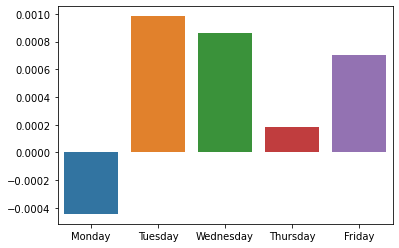

In [13]:
dd = nifty['Total Returns Index'].pct_change().groupby(nifty['day']).mean()
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dd.index = pd.Categorical(dd.index, categories=days[:5], ordered=True)
sns.barplot(x=dd.index, y=dd.values)

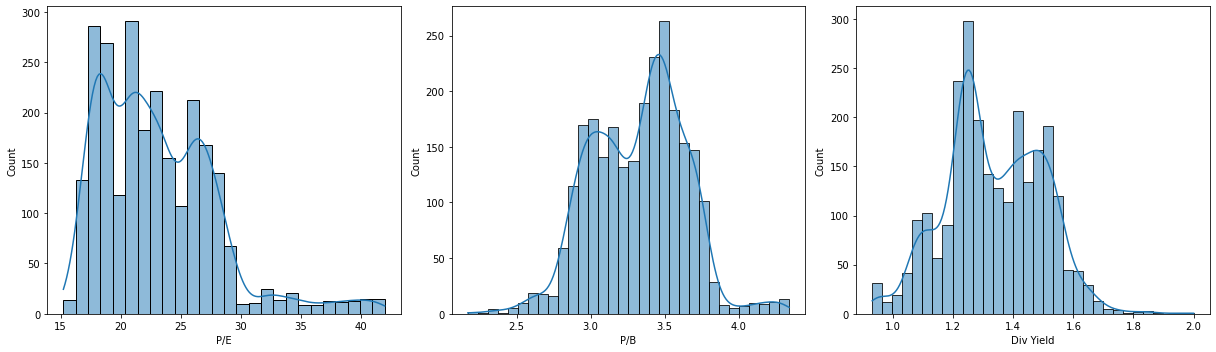

In [14]:
fig, axes = plt.subplots(1,3, figsize=(17,5))
for i, ax in enumerate(axes):
    sns.histplot(nifty[nifty.columns[i+1]], ax=ax, kde=True)
plt.tight_layout()

In [15]:
(nifty['Total Returns Index'].pct_change() > 0).sum() / nifty['Total Returns Index'].pct_change().count()

0.5345713156854998

<AxesSubplot:xlabel='Total Returns Index', ylabel='Count'>

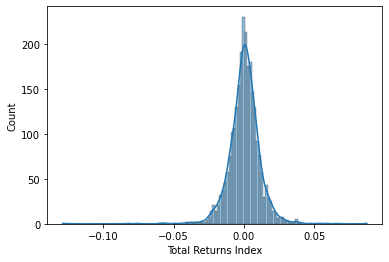

In [16]:
sns.histplot(nifty['Total Returns Index'].pct_change(), kde=True)

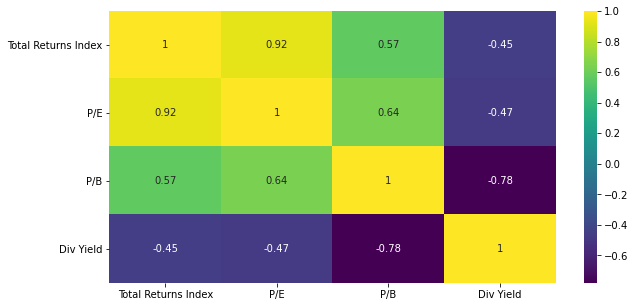

In [17]:
plt.figure(figsize=(10,5))
ax = sns.heatmap(data=nifty[1000:].corr(), annot=True, cmap='viridis')

In [18]:
nifty[(nifty['P/E'] > 200)].count()

Total Returns Index    0
P/E                    0
P/B                    0
Div Yield              0
day                    0
dtype: int64

In [19]:
nifty.loc[nifty[(nifty['P/E'] > 200)].index, 'P/E'] = np.nan

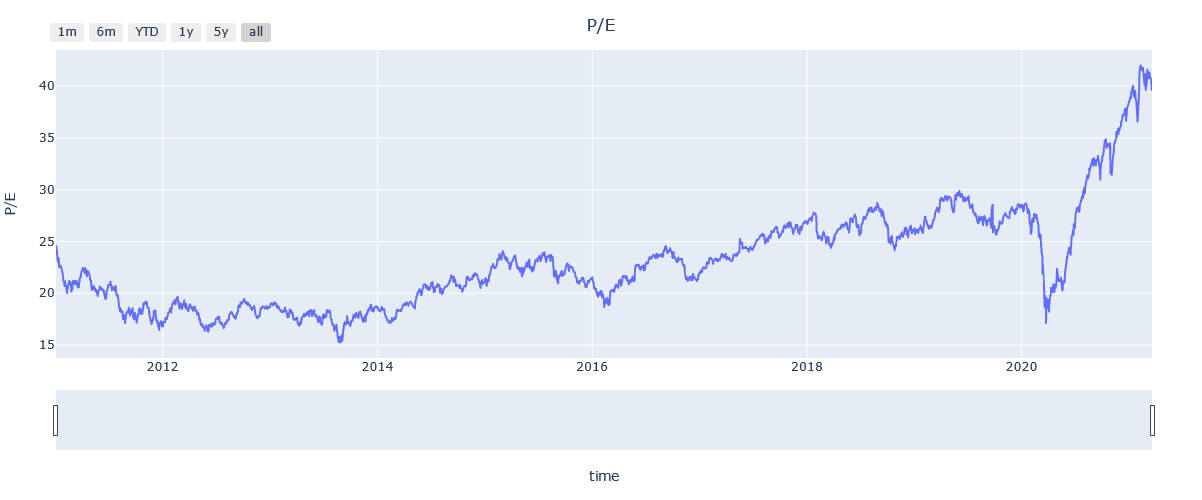

In [20]:
fig = px.line(nifty, x=nifty.index, y="P/E", title='P/E', height=500)
fig.update_layout(
    title={'text': "P/E", 'x':0.5, 'y':0.95, 'xanchor':'center', 'yanchor':'middle'},  xaxis_title='time', yaxis_title='P/E', margin=dict(l=50, r=50, b=50, t=50))
fig.update_xaxes(rangeslider_visible=True, 
                 rangeselector=dict(buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])))

fig.show()

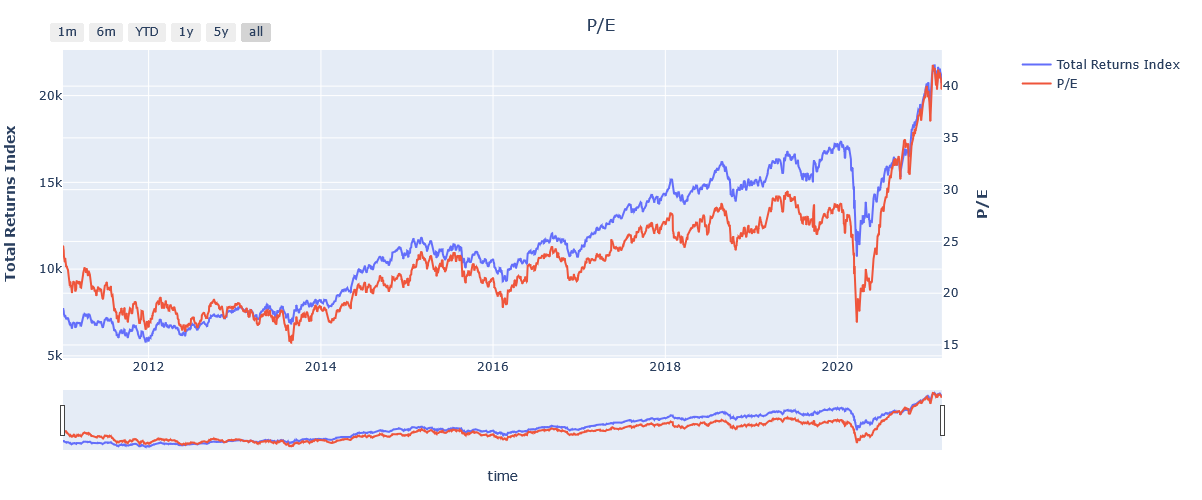

In [21]:
fig = go.Figure()
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=nifty.index, y=nifty["Total Returns Index"], name='Total Returns Index'))
fig.add_trace(go.Scatter(x=nifty.index, y=nifty["P/E"], name='P/E'), secondary_y=True)
fig.update_layout(
    title={'text': "P/E", 'x':0.5,'y':0.95, 'xanchor':'center','yanchor':'middle'},xaxis_title='time', margin=dict(l=50, r=50, b=50, t=50), height=500)
fig.update_xaxes(rangeslider_visible=True, rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(step="all")
        ])))
fig.update_yaxes(title_text="<b>Total Returns Index</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>P/E</b>", secondary_y=True)
fig.show()

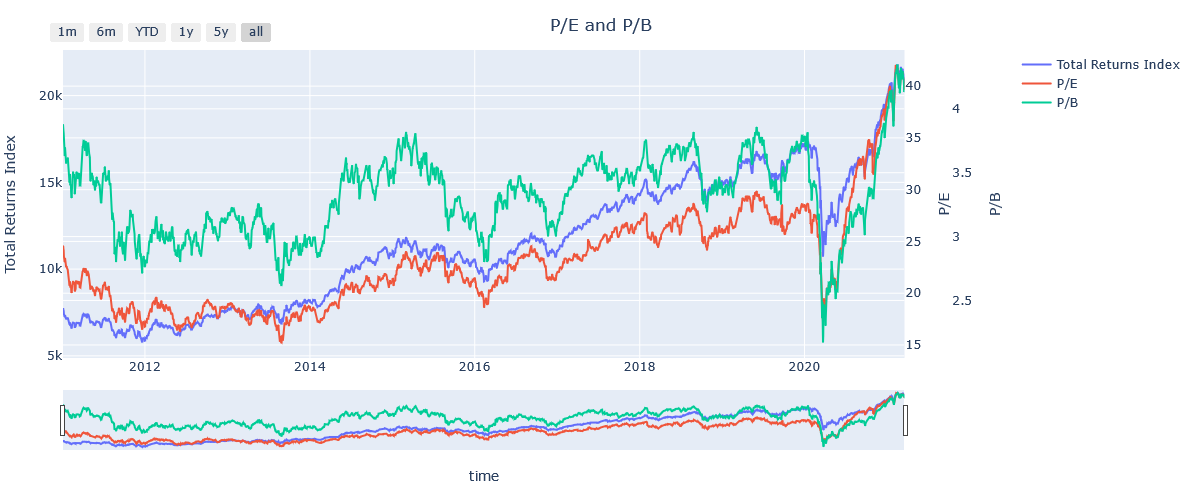

In [22]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=nifty.index, y=nifty["Total Returns Index"], name='Total Returns Index'))
fig.add_trace(go.Scatter(x=nifty.index, y=nifty["P/E"], name='P/E', yaxis='y2'))
fig.add_trace(go.Scatter(x=nifty.index, y=nifty["P/B"], name='P/B', yaxis='y3'))

fig.update_layout(xaxis=dict(domain=[0.0, 0.9]),
                  yaxis=dict(title="Total Returns Index"), yaxis2=dict(title = 'P/E', anchor="x", overlaying="y", side="right"),
                  yaxis3=dict(title = 'P/B', anchor="free", overlaying="y", side="right", position=.95),
    title={'text': "P/E and P/B", 'x':0.5,'y':0.95, 'xanchor':'center','yanchor':'middle'},xaxis_title='time', margin=dict(l=50, r=50, b=50, t=50), height=500)

fig.update_xaxes(rangeslider_visible=True, 
                 rangeselector=dict(buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(count=5, label="5y", step="year", stepmode="backward"),
                    dict(step="all")])))

fig.show()

# yealy returns

In [23]:
np.unique(nifty.index.year, return_counts=True)

(array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021],
       dtype=int64),
 array([247, 251, 250, 244, 248, 247, 248, 246, 245, 252,  54], dtype=int64))

In [24]:
for i in range(10):
    print(nifty.index[i*249])

2011-01-03 00:00:00
2012-01-04 00:00:00
2013-01-01 00:00:00
2013-12-31 00:00:00
2015-01-07 00:00:00
2016-01-08 00:00:00
2017-01-11 00:00:00
2018-01-11 00:00:00
2019-01-16 00:00:00
2020-01-22 00:00:00


In [25]:
nifty_yearly = pd.DataFrame()

In [26]:
nifty_yearly['last 1 year returns'] = nifty['Total Returns Index'].pct_change(periods=249)

In [27]:
nifty_yearly['last 2 year returns'] = nifty['Total Returns Index'].pct_change(periods=249*2)

In [28]:
nifty_yearly['last 3 year returns'] = nifty['Total Returns Index'].pct_change(periods=249*3)

In [29]:
nifty_yearly['last 4 year returns'] = nifty['Total Returns Index'].pct_change(periods=249*4)

In [30]:
nifty_yearly['last 5 year returns'] = nifty['Total Returns Index'].pct_change(periods=249*5)

In [31]:
nifty_yearly['next 1 year returns'] = nifty_yearly['last 1 year returns'].shift(periods=-249)

In [32]:
nifty_yearly['next 2 year returns'] = nifty_yearly['last 2 year returns'].shift(periods=-249*2)

In [33]:
nifty_yearly['next 3 year returns'] = nifty_yearly['last 3 year returns'].shift(periods=-249*3)

In [34]:
nifty_yearly['next 4 year returns'] = nifty_yearly['last 4 year returns'].shift(periods=-249*4)

In [35]:
nifty_yearly['next 5 year returns'] = nifty_yearly['last 5 year returns'].shift(periods=-249*5)

In [36]:
nifty_yearly = nifty_yearly*100

In [37]:
nifty_with_returns = pd.concat([nifty, nifty_yearly], axis=1)

In [38]:
nifty_with_returns

Total Returns Index    P/E   P/B  Div Yield        day  \
Date                                                                 
2011-01-03              7727.31  24.57  3.88       1.01     Monday   
2011-01-04              7713.22  24.53  3.87       1.01    Tuesday   
2011-01-05              7629.67  24.26  3.83       1.03  Wednesday   
2011-01-06              7590.10  24.14  3.81       1.03   Thursday   
2011-01-07              7409.81  23.56  3.72       1.06     Friday   
...                         ...    ...   ...        ...        ...   
2021-03-15             21220.59  40.66  4.23       1.06     Monday   
2021-03-16             21193.46  40.61  4.23       1.07    Tuesday   
2021-03-17             20924.61  40.10  4.17       1.08  Wednesday   
2021-03-18             20692.34  39.65  4.13       1.09   Thursday   
2021-03-19             20956.87  40.16  4.18       1.08     Friday   

            last 1 year returns  last 2 year returns  last 3 year returns  \
Date                                                                        
2011-01-03                  NaN                  NaN                  NaN   
2011-01-04                  NaN                  NaN                  NaN   
2011-01-05                  NaN                  NaN                  NaN   
2011-01-06                  NaN                  NaN                  NaN   
2011-01-07                  NaN                  NaN                  NaN   
...                         ...                  ...                  ...   
2021-03-15            64.142130            36.901645            51.399371   
2021-03-16            68.143213            35.115754            51.439404   
2021-03-17            75.777678            32.914921            46.726929   
2021-03-18            78.061117            31.382689            44.999383   
2021-03-19            70.398512            32.072179            47.078037   

            last 4 year returns  last 5 year returns  next 1 year returns  \
Date                                                                        
2011-01-03                  NaN                  NaN           -22.037164   
2011-01-04                  NaN                  NaN           -21.889691   
2011-01-05                  NaN                  NaN           -20.928690   
2011-01-06                  NaN                  NaN           -20.636487   
2011-01-07                  NaN                  NaN           -18.775785   
...                         ...                  ...                  ...   
2021-03-15            75.647652           116.256823                  NaN   
2021-03-16            75.868098           112.890478                  NaN   
2021-03-17            73.559348           109.915942                  NaN   
2021-03-18            71.487270           107.587889                  NaN   
2021-03-19            70.641597           108.942708                  NaN   

            next 2 year returns  next 3 year returns  next 4 year returns  \
Date                                                                        
2011-01-03            -0.989866             6.179900            38.034840   
2011-01-04            -0.101903             6.334579            40.548824   
2011-01-05             1.265323             6.125822            42.949302   
2011-01-06             1.906035             6.507819            44.361998   
2011-01-07             3.904284             8.752856            47.455333   
...                         ...                  ...                  ...   
2021-03-15                  NaN                  NaN                  NaN   
2021-03-16                  NaN                  NaN                  NaN   
2021-03-17                  NaN                  NaN                  NaN   
2021-03-18                  NaN                  NaN                  NaN   
2021-03-19                  NaN                  NaN                  NaN   

            next 5 year returns  
Date                             
2011-01-03            30.91

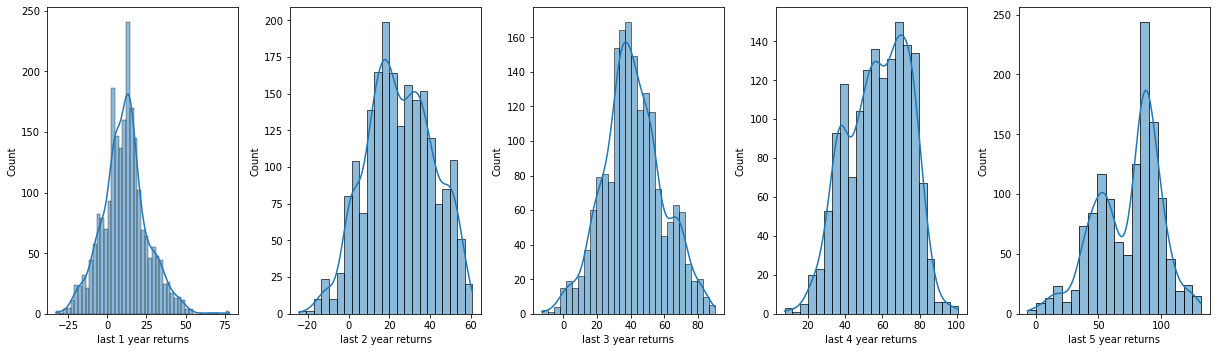

In [39]:
fig, axes = plt.subplots(1,5, figsize=(17,5))
for i, ax in enumerate(axes):
    sns.histplot(nifty_yearly.iloc[:,i], ax=ax, kde=True)
plt.tight_layout()

yearly correlations between returns and metric

In [40]:
nifty['Total Returns Index'].count()

2532

In [41]:
for i in range(0, nifty['Total Returns Index'].count(), 249):
    print(f"On {nifty.index[i].date()} next 1 year returns are {round(nifty_yearly['next 1 year returns'].iloc[i], 2)} and correlation between P/B and returns is {round(nifty['P/B'].iloc[i:i+249].corr(nifty_yearly['next 1 year returns'].iloc[i:i+249]),2)}")

On 2011-01-03 next 1 year returns are -22.04 and correlation between P/B and returns is -0.93
On 2012-01-04 next 1 year returns are 27.0 and correlation between P/B and returns is -0.62
On 2013-01-01 next 1 year returns are 7.24 and correlation between P/B and returns is -0.84
On 2013-12-31 next 1 year returns are 30.0 and correlation between P/B and returns is -0.93
On 2015-01-07 next 1 year returns are -5.16 and correlation between P/B and returns is -0.88
On 2016-01-08 next 1 year returns are 11.73 and correlation between P/B and returns is -0.57
On 2017-01-11 next 1 year returns are 28.69 and correlation between P/B and returns is -0.5
On 2018-01-11 next 1 year returns are 3.72 and correlation between P/B and returns is -0.7
On 2019-01-16 next 1 year returns are 12.61 and correlation between P/B and returns is -0.37
On 2020-01-22 next 1 year returns are 21.25 and correlation between P/B and returns is -0.98
On 2021-01-19 next 1 year returns are nan and correlation between P/B and r

In [42]:
nifty['P/E'].iloc[:1000].corr(nifty_yearly['next 1 year returns'].iloc[:1000])

-0.7522437414982931

In [43]:
nifty['P/E'].iloc[1000:].corr(nifty_yearly['next 1 year returns'].iloc[1000:])

-0.43661750713032804

In [44]:
nifty['Div Yield'].corr(nifty_yearly['next 1 year returns'])

0.49361168621089546

In [45]:
def compare_three(y1, y2, y3):
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=nifty.index, y=nifty_with_returns[y1], name=y1))
    fig.add_trace(go.Scatter(x=nifty.index, y=nifty_with_returns[y2], name=y2, yaxis='y2'))
    fig.add_trace(go.Scatter(x=nifty.index, y=nifty_with_returns[y3], name=y3, yaxis='y3'))

    fig.update_layout(xaxis=dict(domain=[0.0, 0.9]),
                      yaxis=dict(title=y1), 
                      yaxis2=dict(title = y2, anchor="x", overlaying="y", side="right"),
                      yaxis3=dict(title = y3, anchor="free", overlaying="y", side="right", position=.95),
        title={'text': y1+' '+y2+' '+y3, 'x':0.5,'y':0.95, 'xanchor':'center','yanchor':'middle'},xaxis_title='time', margin=dict(l=50, r=50, b=50, t=50), height=500)

    fig.update_layout(hovermode="x unified")

    fig.update_xaxes(rangeslider_visible=True, 
                     rangeselector=dict(buttons=list([
                        dict(count=1, label="1m", step="month", stepmode="backward"),
                        dict(count=6, label="6m", step="month", stepmode="backward"),
                        dict(count=1, label="YTD", step="year", stepmode="todate"),
                        dict(count=1, label="1y", step="year", stepmode="backward"),
                        dict(count=5, label="5y", step="year", stepmode="backward"),
                        dict(step="all")])))
    fig.show()

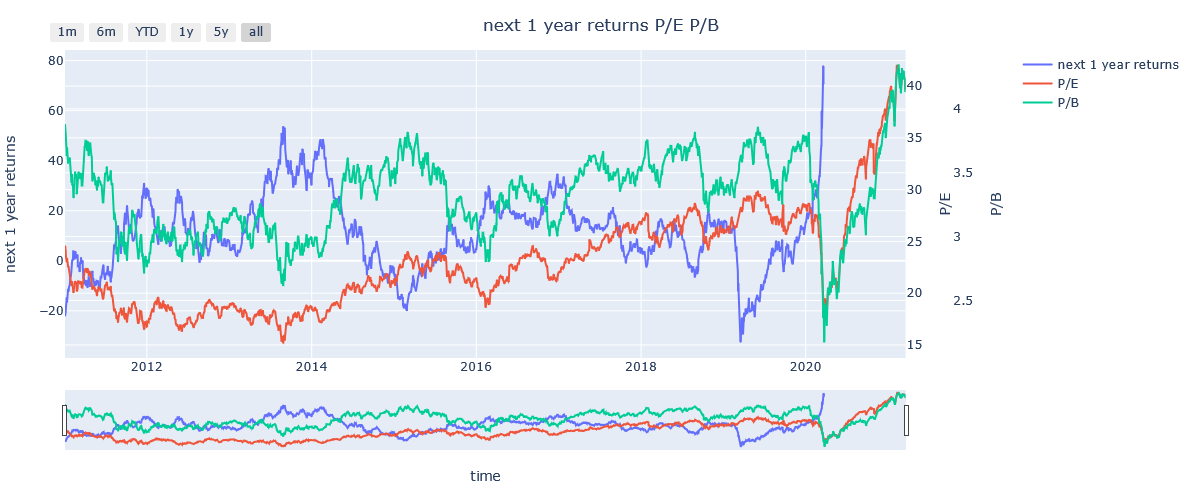

In [46]:
compare_three('next 1 year returns', 'P/E', 'P/B')

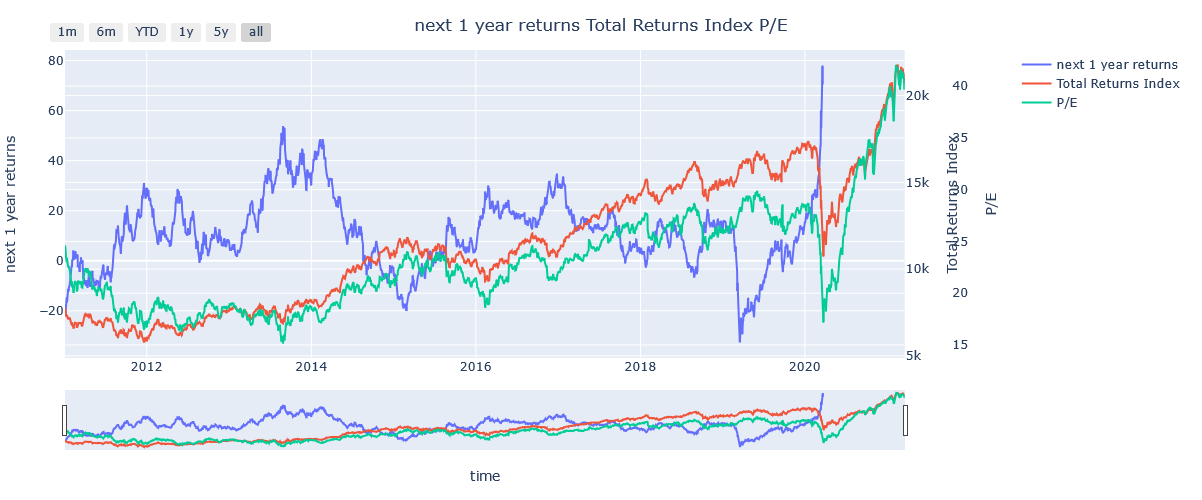

In [47]:
compare_three('next 1 year returns', 'Total Returns Index', 'P/E')

<AxesSubplot:>

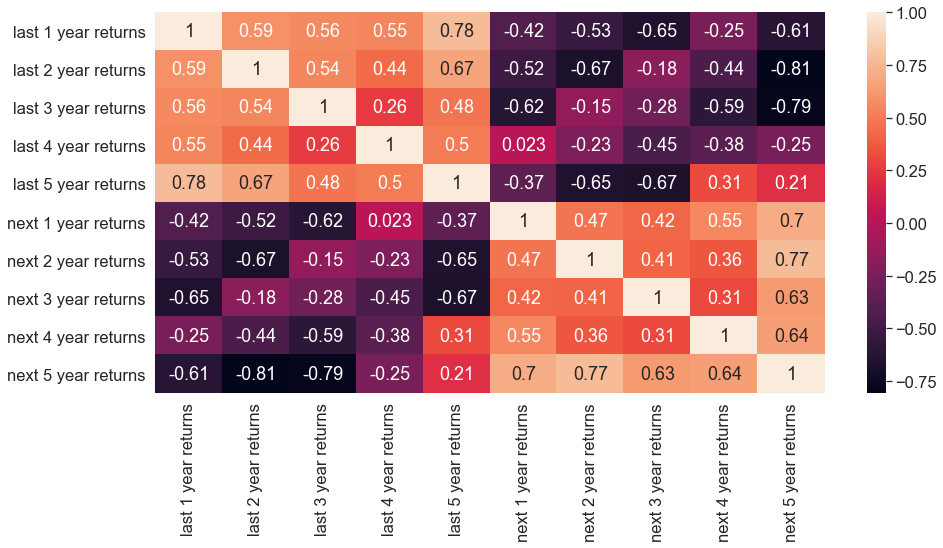

In [48]:
plt.figure(figsize = (15,7))
sns.set(font_scale=1.5)
sns.heatmap(nifty_yearly.corr(), annot=True)

In [49]:
nifty_with_returns.iloc[1000:, :]

Total Returns Index    P/E   P/B  Div Yield        day  \
Date                                                                 
2015-01-13             10926.16  21.21  3.50       1.27    Tuesday   
2015-01-14             10897.36  21.14  3.49       1.27  Wednesday   
2015-01-15             11182.52  21.70  3.58       1.24   Thursday   
2015-01-16             11208.42  21.75  3.59       1.24     Friday   
2015-01-19             11257.01  21.80  3.60       1.23     Monday   
...                         ...    ...   ...        ...        ...   
2021-03-15             21220.59  40.66  4.23       1.06     Monday   
2021-03-16             21193.46  40.61  4.23       1.07    Tuesday   
2021-03-17             20924.61  40.10  4.17       1.08  Wednesday   
2021-03-18             20692.34  39.65  4.13       1.09   Thursday   
2021-03-19             20956.87  40.16  4.18       1.08     Friday   

            last 1 year returns  last 2 year returns  last 3 year returns  \
Date                                                                        
2015-01-13            35.587550            41.914585            81.541100   
2015-01-14            35.870869            41.226846            77.078249   
2015-01-15            39.147855            45.655988            81.284855   
2015-01-16            39.611375            46.062596            82.821193   
2015-01-19            40.145212            47.123533            82.303300   
...                         ...                  ...                  ...   
2021-03-15            64.142130            36.901645            51.399371   
2021-03-16            68.143213            35.115754            51.439404   
2021-03-17            75.777678            32.914921            46.726929   
2021-03-18            78.061117            31.382689            44.999383   
2021-03-19            70.398512            32.072179            47.078037   

            last 4 year returns  last 5 year returns  next 1 year returns  \
Date                                                                        
2015-01-13            47.455333                  NaN            -8.197116   
2015-01-14            50.683981                  NaN            -9.163320   
2015-01-15            54.862172                  NaN           -12.512922   
2015-01-16            52.330744                  NaN           -11.716549   
2015-01-19            55.952930                  NaN           -13.584780   
...                         ...                  ...                  ...   
2021-03-15            75.647652           116.256823                  NaN   
2021-03-16            75.868098           112.890478                  NaN   
2021-03-17            73.559348           109.915942                  NaN   
2021-03-18            71.487270           107.587889                  NaN   
2021-03-19            70.641597           108.942708                  NaN   

            next 2 year returns  next 3 year returns  next 4 year returns  \
Date                                                                        
2015-01-13             3.665149            34.851311            38.510053   
2015-01-14             4.174038            35.580269            37.715924   
2015-01-15             1.735745            33.071973            34.478364   
2015-01-16             0.469022            33.647026            33.311296   
2015-01-19             0.551479            34.496105            31.270293   
...                         ...                  ...                  ...   
2021-03-15                  NaN                  NaN                  NaN   
2021-03-16                  NaN                  NaN                  NaN   
2021-03-17                  NaN                  NaN                  NaN   
2021-03-18                  NaN                  NaN                  NaN   
2021-03-19                  NaN                  NaN                  NaN   

            next 5 year returns  
Date                             
2015-01-13            54.87

<AxesSubplot:>

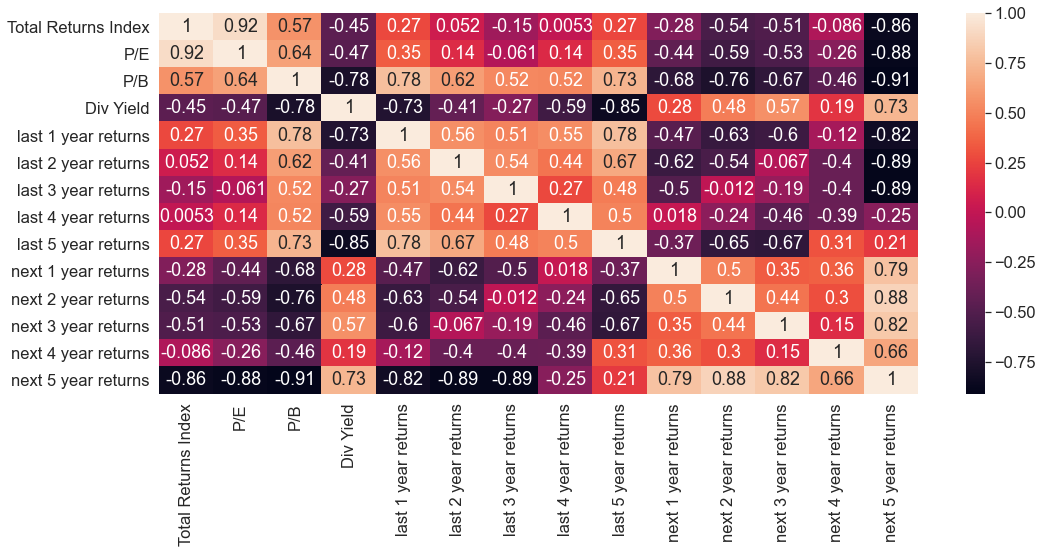

In [50]:
plt.figure(figsize = (17,7))
sns.set(font_scale=1.5)
sns.heatmap(nifty_with_returns.iloc[1000:, :].corr(), annot=True)

# Linear Regression

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [67]:
data_set = nifty_with_returns[['P/E', 'P/B', 'Div Yield','next 1 year returns']]

In [68]:
X = data_set[1000:].dropna()[['P/E', 'P/B', 'Div Yield']]
Y = data_set[1000:].dropna()['next 1 year returns']

In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=101)

In [70]:
model = LinearRegression()

In [71]:
model.fit(X_train, Y_train)

LinearRegression()

In [72]:
model.coef_

array([ -0.18109067, -48.38341258, -27.95624389])

In [73]:
model.score(X_test, Y_test)

0.5494868591151141

In [74]:
pred = model.predict(X_test)

<AxesSubplot:ylabel='next 1 year returns'>

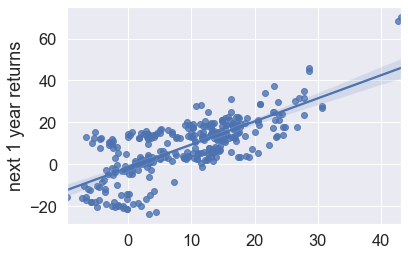

In [75]:
sns.regplot(x=pred, y=Y_test)

In [76]:
nifty.tail(1)

Total Returns Index    P/E   P/B  Div Yield     day
Date                                                           
2021-03-19             20956.87  40.16  4.18       1.08  Friday

In [77]:
nifty.tail(1).values[0][1:4]

array([40.16, 4.18, 1.08], dtype=object)

In [78]:
arr = nifty.tail(1).values[0][1:4]

In [79]:
model.predict(arr.reshape(1,-1))

array([-23.75737282])